In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from collections import defaultdict, OrderedDict
import shutil
from tqdm import tqdm

### Json에 있는 Segmentation Annotation 추출 및 line coord 교체

In [2]:
json_dir = os.path.join("/opt/ml/team_github/utils/crosswalk_filtering_closed.json")

with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)
    images = datas["images"]
    annotations = datas["annotations"]

img_df = pd.DataFrame(images)
annos_df = pd.DataFrame(annotations)

In [3]:
import os
file_list = os.listdir('/opt/ml/data/images')
len(file_list)

1896

In [4]:
new_img_df = img_df[img_df['file_name'].isin(file_list)].copy()
len(new_img_df)
new_img_df

,license,url,file_name,height,width,data_captured,id
0,0,None,MP_SEL_SUR_000033.jpg,1080,1920,None,0
3,0,None,MP_SEL_SUR_000066.jpg,1080,1920,None,3
5,0,None,MP_SEL_SUR_000084.jpg,1080,1920,None,5
6,0,None,MP_SEL_SUR_000110.jpg,1080,1920,None,6
7,0,None,MP_SEL_SUR_000119.jpg,1080,1920,None,7
...,...,...,...,...,...,...,...
3470,0,None,MP_SEL_SUR_047091.jpg,1080,1920,None,3470
3471,0,None,MP_SEL_SUR_047094.jpg,1080,1920,None,3471
3473,0,None,MP_SEL_SUR_047115.jpg,1080,1920,None,3473
3474,0,None,MP_SEL_SUR_047118.jpg,1080,1920,None,3474


In [5]:
new_annos_df = annos_df[annos_df['image_id'].isin(new_img_df['id'])].copy()
len(new_annos_df)
new_annos_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,[],0,"[[1579, 16, 1362, 19, 1351, 27, 1302, 39, 1321...",0
1,1,0,1,[],0,"[[751, 64, 434, 286, 0, 655, 4, 798, 354, 799,...",0
4,0,3,1,[],0,"[[170, 0, 1, 80, 0, 746, 424, 756, 1167, 858, ...",0
7,0,5,1,[],0,"[[1384, 603, 1088, 101, 899, 45, 765, 0, 313, ...",0
8,0,6,1,[],0,"[[1840, 463, 1370, 481, 832, 528, 478, 649, 44...",0
...,...,...,...,...,...,...,...
4879,0,3470,1,[],0,"[[514, 4, 566, 4, 632, 7, 648, 7, 579, 0, 962,...",0
4880,0,3471,1,[],0,"[[0, 0, 1374, 0, 1650, 545, 1139, 545, 575, 54...",0
4882,0,3473,1,[],0,"[[1520, 0, 1782, 544, 1217, 548, 612, 555, 291...",0
4883,0,3474,1,[],0,"[[577, 0, 0, 333, 0, 784, 315, 780, 535, 778, ...",0


In [6]:
new_annos_df = new_annos_df.reset_index()
new_annos_df['id'] = new_annos_df.index
new_annos_df

,index,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,0,1,[],0,"[[1579, 16, 1362, 19, 1351, 27, 1302, 39, 1321...",0
1,1,1,0,1,[],0,"[[751, 64, 434, 286, 0, 655, 4, 798, 354, 799,...",0
2,4,2,3,1,[],0,"[[170, 0, 1, 80, 0, 746, 424, 756, 1167, 858, ...",0
3,7,3,5,1,[],0,"[[1384, 603, 1088, 101, 899, 45, 765, 0, 313, ...",0
4,8,4,6,1,[],0,"[[1840, 463, 1370, 481, 832, 528, 478, 649, 44...",0
...,...,...,...,...,...,...,...,...
2486,4879,2486,3470,1,[],0,"[[514, 4, 566, 4, 632, 7, 648, 7, 579, 0, 962,...",0
2487,4880,2487,3471,1,[],0,"[[0, 0, 1374, 0, 1650, 545, 1139, 545, 575, 54...",0
2488,4882,2488,3473,1,[],0,"[[1520, 0, 1782, 544, 1217, 548, 612, 555, 291...",0
2489,4883,2489,3474,1,[],0,"[[577, 0, 0, 333, 0, 784, 315, 780, 535, 778, ...",0


In [7]:
new_annos_df.drop(columns='index', inplace=True)
new_annos_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,[],0,"[[1579, 16, 1362, 19, 1351, 27, 1302, 39, 1321...",0
1,1,0,1,[],0,"[[751, 64, 434, 286, 0, 655, 4, 798, 354, 799,...",0
2,2,3,1,[],0,"[[170, 0, 1, 80, 0, 746, 424, 756, 1167, 858, ...",0
3,3,5,1,[],0,"[[1384, 603, 1088, 101, 899, 45, 765, 0, 313, ...",0
4,4,6,1,[],0,"[[1840, 463, 1370, 481, 832, 528, 478, 649, 44...",0
...,...,...,...,...,...,...,...
2486,2486,3470,1,[],0,"[[514, 4, 566, 4, 632, 7, 648, 7, 579, 0, 962,...",0
2487,2487,3471,1,[],0,"[[0, 0, 1374, 0, 1650, 545, 1139, 545, 575, 54...",0
2488,2488,3473,1,[],0,"[[1520, 0, 1782, 544, 1217, 548, 612, 555, 291...",0
2489,2489,3474,1,[],0,"[[577, 0, 0, 333, 0, 784, 315, 780, 535, 778, ...",0


In [8]:
new_dict = dict()

for idx, id in enumerate(new_img_df['id'].tolist()):
    new_dict[id] = idx

In [9]:
new_img_df['id'].replace(new_dict, inplace=True)
new_img_df

,license,url,file_name,height,width,data_captured,id
0,0,None,MP_SEL_SUR_000033.jpg,1080,1920,None,0
3,0,None,MP_SEL_SUR_000066.jpg,1080,1920,None,1
5,0,None,MP_SEL_SUR_000084.jpg,1080,1920,None,2
6,0,None,MP_SEL_SUR_000110.jpg,1080,1920,None,3
7,0,None,MP_SEL_SUR_000119.jpg,1080,1920,None,4
...,...,...,...,...,...,...,...
3470,0,None,MP_SEL_SUR_047091.jpg,1080,1920,None,1891
3471,0,None,MP_SEL_SUR_047094.jpg,1080,1920,None,1892
3473,0,None,MP_SEL_SUR_047115.jpg,1080,1920,None,1893
3474,0,None,MP_SEL_SUR_047118.jpg,1080,1920,None,1894


In [10]:
new_annos_df['image_id'] = new_annos_df['image_id'].replace(new_dict)
new_annos_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,[],0,"[[1579, 16, 1362, 19, 1351, 27, 1302, 39, 1321...",0
1,1,0,1,[],0,"[[751, 64, 434, 286, 0, 655, 4, 798, 354, 799,...",0
2,2,1,1,[],0,"[[170, 0, 1, 80, 0, 746, 424, 756, 1167, 858, ...",0
3,3,2,1,[],0,"[[1384, 603, 1088, 101, 899, 45, 765, 0, 313, ...",0
4,4,3,1,[],0,"[[1840, 463, 1370, 481, 832, 528, 478, 649, 44...",0
...,...,...,...,...,...,...,...
2486,2486,1891,1,[],0,"[[514, 4, 566, 4, 632, 7, 648, 7, 579, 0, 962,...",0
2487,2487,1892,1,[],0,"[[0, 0, 1374, 0, 1650, 545, 1139, 545, 575, 54...",0
2488,2488,1893,1,[],0,"[[1520, 0, 1782, 544, 1217, 548, 612, 555, 291...",0
2489,2489,1894,1,[],0,"[[577, 0, 0, 333, 0, 784, 315, 780, 535, 778, ...",0


In [11]:
datas["images"] = new_img_df.to_dict('records')
datas["annotations"] = new_annos_df.to_dict('records')

In [12]:
with open("crosswalk_filtering_poly_closed_noise_filtering.json", "w") as json_file:
    json.dump(datas, json_file, indent=4)

In [13]:
dirpath = '/opt/ml/data/images'
annpath = '/opt/ml/data/anns'

0


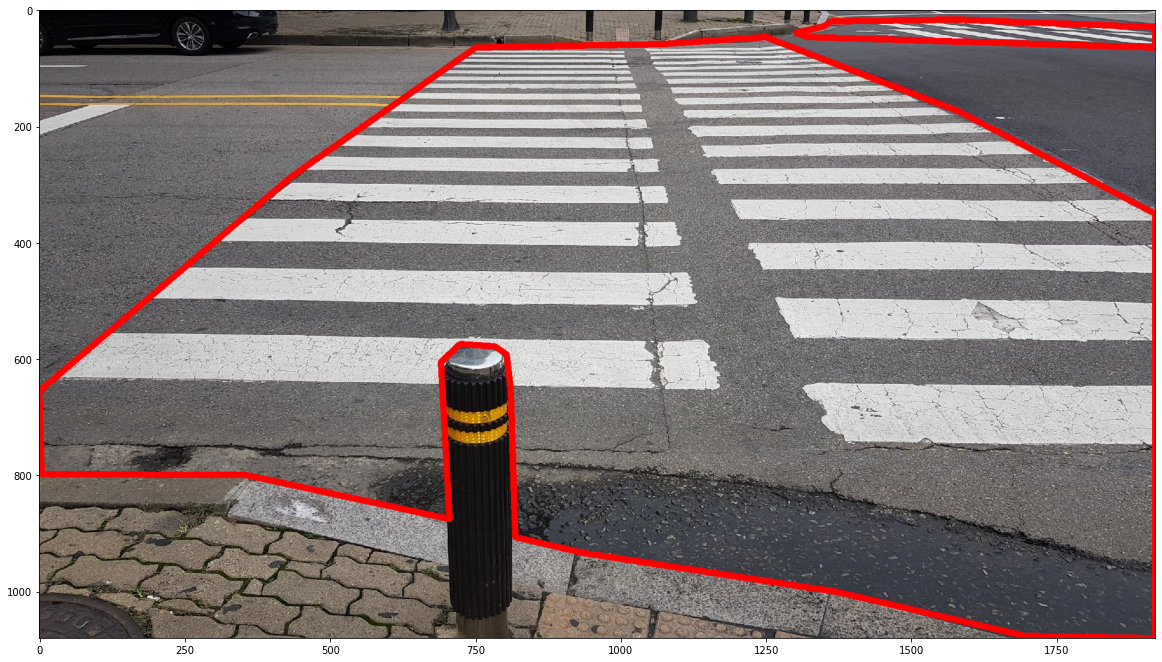

In [14]:
imageName = "MP_SEL_SUR_000033.jpg"
print(img_df[img_df.file_name==imageName]['id'].item())

image_path = os.path.join(dirpath, imageName)
image =cv2.imread(image_path)
image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ann_data = annos_df[annos_df.image_id==img_df[img_df.file_name==imageName]['id'].item()]['segmentation'].values

all_coord = []
fill_image = []
mask_image = np.zeros([image.shape[0], image.shape[1]])

for each_ann in ann_data:
    target = each_ann[0]
    coord = []
    for seg_idx in range(0, len(target), 2):
        x, y = target[seg_idx], target[seg_idx+1]
        coord.append([x, y])

    fill_image = cv2.fillPoly(mask_image, [np.array(coord)], 255)
    np_coord = [np.array(coord)]
    np_coord
    image = cv2.polylines(image, np_coord, False, 255, 10)

plt.figure(figsize=(20,16))
plt.imshow(image)
# plt.figure(figsize=(20,16))
# plt.imshow(fill_image)

# output_path = os.path.join(annpath, imageName.split('.')[0] + ".png")
# cv2.imwrite(output_path, image)

In [15]:
def draw_line(seg_data, mask_image):
    coord = []
    for seg_idx in range(0, len(seg_data), 2):
        x, y = seg_data[seg_idx], seg_data[seg_idx+1]
        if x >= 1920:
            x = 1919
        if y >= 1080:
            y = 1079
        coord.append([x, y])
    
    line_image = cv2.polylines(mask_image, [np.array(coord)], False, 1, 1)
    
    return line_image, np.argwhere(line_image==1)

In [16]:
each_area = []
image_see = []
new_seg = {}

for idx in tqdm(range(len(set(new_annos_df["image_id"])))):
    seg_datas = new_annos_df[new_annos_df['image_id']==idx]["segmentation"]
    h = new_img_df[new_img_df["id"] == idx]["height"].values[0] # image h
    w = new_img_df[new_img_df["id"] == idx]["width"].values[0]

    max_area_ratio = 0
    for index, seg_data in seg_datas.items():
        mask_image = np.zeros([h+1, w+1])
        new_image, new_coord = draw_line(seg_data[0], mask_image)
        
        new_seg.update({index: [list(new_coord.flatten().tolist())]})

100%|██████████| 1896/1896 [00:31<00:00, 60.89it/s]


In [17]:
new_annos_df = new_annos_df.drop('segmentation', axis=1)
new_annos_df

,id,image_id,category_id,bbox,area,iscrowd
0,0,0,1,[],0,0
1,1,0,1,[],0,0
2,2,1,1,[],0,0
3,3,2,1,[],0,0
4,4,3,1,[],0,0
...,...,...,...,...,...,...
2486,2486,1891,1,[],0,0
2487,2487,1892,1,[],0,0
2488,2488,1893,1,[],0,0
2489,2489,1894,1,[],0,0


In [18]:
s_new_seg = pd.Series(new_seg)
new_annos_df.insert(5, "segmentation", s_new_seg) # insert new_series

In [19]:
new_annos_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,[],0,"[[16, 1543, 16, 1544, 16, 1545, 16, 1546, 16, ...",0
1,1,0,1,[],0,"[[46, 1243, 46, 1244, 46, 1245, 46, 1246, 46, ...",0
2,2,1,1,[],0,"[[0, 169, 0, 170, 0, 171, 0, 172, 0, 173, 0, 1...",0
3,3,2,1,[],0,"[[0, 765, 0, 766, 1, 765, 1, 767, 1, 768, 1, 7...",0
4,4,3,1,[],0,"[[69, 768, 69, 769, 69, 770, 69, 771, 69, 772,...",0
...,...,...,...,...,...,...,...
2486,2486,1891,1,[],0,"[[0, 579, 0, 580, 0, 581, 0, 582, 0, 583, 0, 5...",0
2487,2487,1892,1,[],0,"[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0,...",0
2488,2488,1893,1,[],0,"[[0, 545, 0, 546, 0, 547, 0, 548, 0, 549, 0, 5...",0
2489,2489,1894,1,[],0,"[[0, 577, 0, 578, 0, 579, 0, 580, 0, 581, 0, 5...",0


In [20]:
datas["images"] = new_img_df.to_dict('records')
datas["annotations"] = new_annos_df.to_dict('records')

In [21]:
with open("crosswalk_filtering_seg_noise_filtering.json", "w") as json_file:
    json.dump(datas, json_file, indent=4)

In [25]:
new_img_df.to_csv('image_info.csv')
new_annos_df.to_csv('anno_info.csv')